In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
%matplotlib inline

In [31]:
df = pd.read_excel("dataset/58606.23.06.2020.23.06.2025.1.0.0.cn.utf8.00000000.xls")

T           2
Po          0
P           6
Pa       1799
U           2
Ff          0
ff10    14584
ff3      1146
Tn        316
Tx       1555
Nh      14584
Td          0
tR        117
Tg      14584
E'      14584
sss     14584
dtype: int64


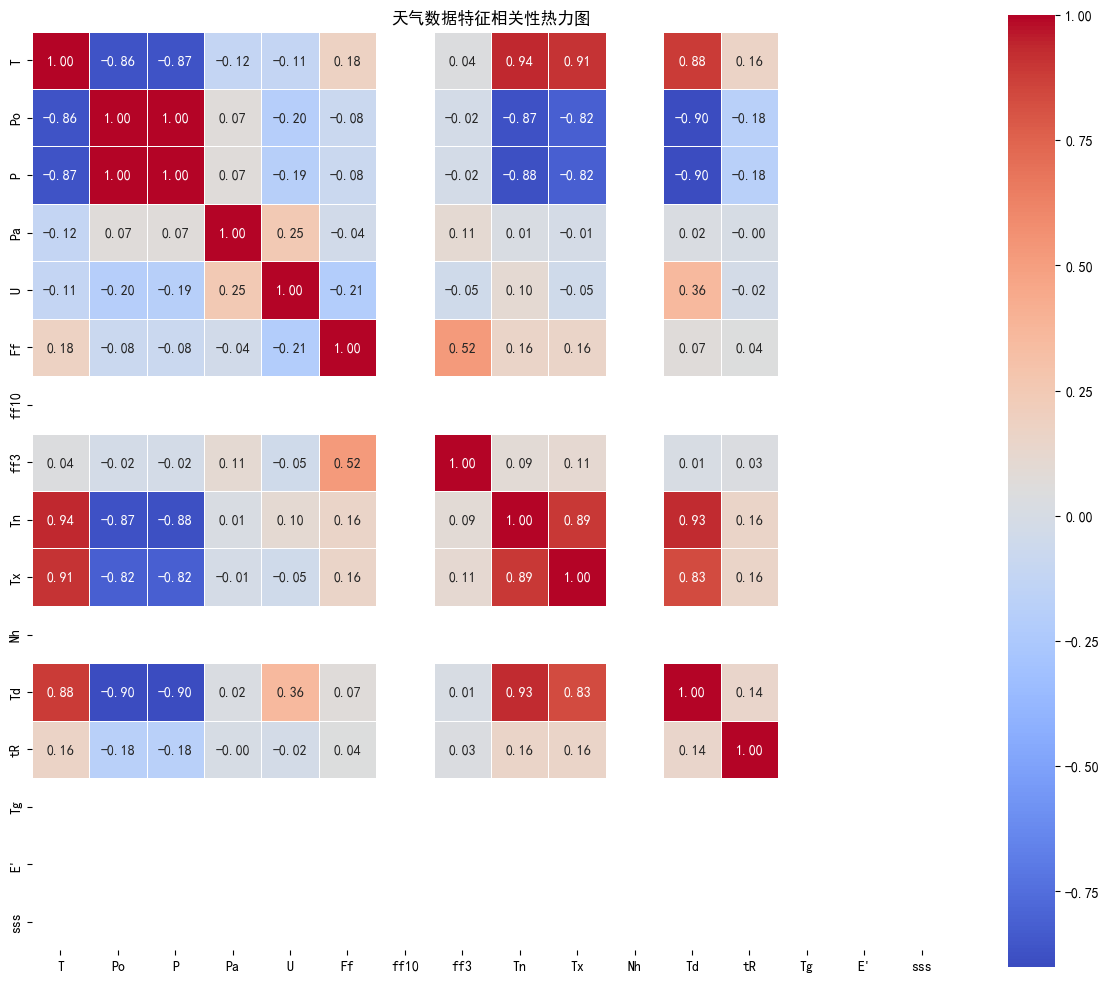

In [32]:
numeric_df = df.select_dtypes(include=[np.number])

# 检查缺失值情况
print(numeric_df.isnull().sum())

# 可以选择用均值填充缺失值，或直接丢弃含缺失值的行
numeric_df = numeric_df.fillna(numeric_df.mean())

# 计算相关系数矩阵
corr_matrix = numeric_df.corr()

# 显示部分相关系数矩阵
corr_matrix.head()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('天气数据特征相关性热力图')
plt.tight_layout()
plt.show()

In [33]:
# 假设时间列名为 'datetime'，气温为 'T'
df['datetime'] = pd.to_datetime(df['当地时间 莲塘镇'])
df['hour'] = df['datetime'].dt.hour

# 先计算每一天的最高温和最低温
df['date'] = df['datetime'].dt.date
for day, group in df.groupby('date'):
    Tmax = group['T'].max()
    Tmin = group['T'].min()
    # 跳过当天全部缺失的情况
    if pd.isna(Tmax) or pd.isna(Tmin):
        continue
    for idx, row in group.iterrows():
        if pd.isna(row['T']):
            hour = row['hour']
            # 假设最低温在5点，最高温在14点
            # 归一化到[0, pi]区间
            x = (hour - 5) / (14 - 5)
            x = min(max(x, 0), 1)
            T_est = Tmin + (Tmax - Tmin) * np.sin(np.pi * x)
            # 限制范围
            T_est = min(max(T_est, Tmin), Tmax)
            df.at[idx, 'T'] = T_est

# 删除辅助列
df.drop(columns=['hour', 'date'], inplace=True)

C:\Users\17803\AppData\Local\Temp\ipykernel_1648\3872173488.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['当地时间 莲塘镇'])


In [34]:
df.drop(columns=['ff10','ff3','N',"Cl","Nh",'Tg','sss',"E'","E",'Cm','Ch',"W1","W2","H","当地时间 莲塘镇"],axis=1, inplace=True)

In [35]:
dd_map = {
    "从北方吹来的风": 0,
    "从东北偏北方向吹来的风": 1,
    "从东北方吹来的风": 2,
    "从东北偏东方向吹来的风": 3,
    "从东方吹来的风": 4,
    "从东南偏东方向吹来的风": 5,
    "从东南方吹来的风": 6,
    "从东南偏南方向吹来的风": 7,
    "从南方吹来的风": 8,
    "从西南偏南方向吹来的风": 9,
    "从西南方吹来的风": 10,
    "从西南偏西方向吹来的风": 11,
    "从西方吹来的风": 12,
    "从西北偏西方向吹来的风": 13,
    "从西北方吹来的风": 14,
    "从西北偏北方向吹来的风": 15,
    "无风": 16
}
df["DD"] = df["DD"].map(dd_map).fillna(df["DD"])


In [36]:
# 先替换“无降水”为0
df["RRR"] = df["RRR"].replace("无降水", 0)
# 强制转换为数值类型，无法转换的变为NaN
df["RRR"] = pd.to_numeric(df["RRR"], errors="coerce")

for row in df.index:
    if pd.isna(df.loc[row, "RRR"]):
        # 向下查找下一个非缺失值
        next_row = row + 1
        while next_row in df.index and pd.isna(df.loc[next_row, "RRR"]):
            next_row += 1
        prev_row = row - 1
        while prev_row in df.index and pd.isna(df.loc[prev_row, "RRR"]):
            prev_row -= 1
        # 如果找到的前后都不是缺失值
        if next_row in df.index and prev_row in df.index:
            if df.loc[next_row, "RRR"] != 0 or df.loc[prev_row, "RRR"] != 0:
                df.loc[row, "RRR"] = np.average([df.loc[next_row, "RRR"], df.loc[prev_row, "RRR"]])
            elif df.loc[next_row, "RRR"] == 0 and df.loc[prev_row, "RRR"] == 0:
                df.loc[row, "RRR"] = 0
        # 只找到后面有数据
        elif next_row in df.index:
            df.loc[row, "RRR"] = df.loc[next_row, "RRR"]
        # 只找到前面有数据
        elif prev_row in df.index:
            df.loc[row, "RRR"] = df.loc[prev_row, "RRR"]
        # 前后都没有数据，直接填0
        else:
            df.loc[row, "RRR"] = 0

In [37]:
for i in range(len(df) - 1):
    # 填补P
    if pd.isna(df.loc[i, 'P']) and not pd.isna(df.loc[i, 'Pa']) and not pd.isna(df.loc[i + 1, 'P']):
        df.loc[i, 'P'] = df.loc[i + 1, 'P'] + df.loc[i, 'Pa']
    # 填补Pa
    if pd.isna(df.loc[i, 'Pa']) and not pd.isna(df.loc[i, 'P']) and not pd.isna(df.loc[i + 1, 'P']):
        df.loc[i, 'Pa'] = df.loc[i, 'P'] - df.loc[i + 1, 'P']

# 对剩余缺失值做线性插值
df['P'] = df['P'].interpolate(method='linear', limit_direction='both')
df['Pa'] = df['Pa'].interpolate(method='linear', limit_direction='both')

In [38]:
# 对U列缺失值做线性插值，保持趋势
df['U'] = df['U'].interpolate(method='linear', limit_direction='both')

In [39]:
for idx in df.index:
    # 填补Tn
    if pd.isna(df.loc[idx, 'Tn']):
        next_rows = df.loc[idx:idx+5, 'T']  # 包含当前行及后5行
        if next_rows.notna().any():
            df.loc[idx, 'Tn'] = next_rows.min()
    # 填补Tx
    if pd.isna(df.loc[idx, 'Tx']):
        next_rows = df.loc[idx:idx+5, 'T']
        if next_rows.notna().any():
            df.loc[idx, 'Tx'] = next_rows.max()

C:\Users\17803\AppData\Local\Temp\ipykernel_1648\2895611042.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot['VV'] = df_plot['VV'].replace('低于 0.1', 0.05)


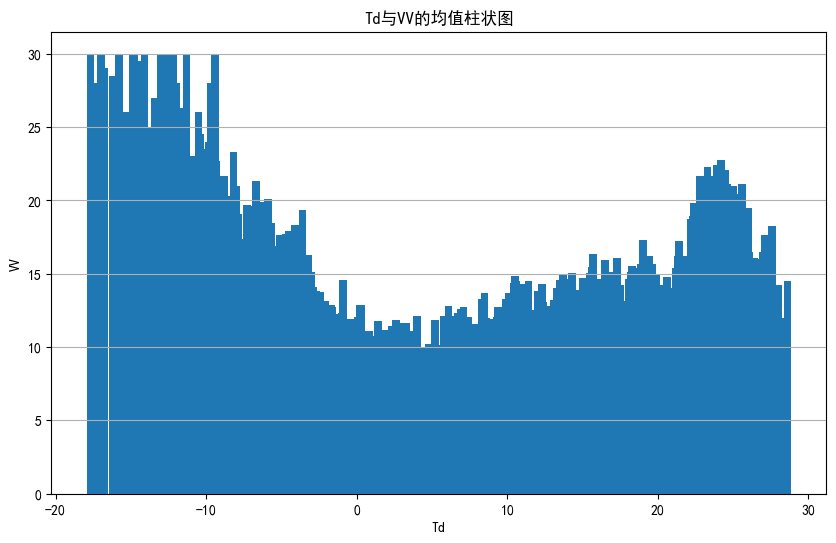

In [40]:
# 只保留Td和VV都非缺失的数据
df_plot = df[['Td', 'VV']].dropna()
df_plot['VV'] = df_plot['VV'].replace('低于 0.1', 0.05)
df_plot['Td'] = pd.to_numeric(df_plot['Td'], errors='coerce')
df_plot['VV'] = pd.to_numeric(df_plot['VV'], errors='coerce')
df_plot = df_plot.dropna()

# 按Td分组求VV均值
bar_data = df_plot.groupby('Td')['VV'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(bar_data['Td'], bar_data['VV'], width=0.5)
plt.xlabel('Td')
plt.ylabel('VV')
plt.title('Td与VV的均值柱状图')
plt.grid(axis='y')
plt.show()

In [41]:
# 1. 填补VV缺失值
df['VV'] = df['VV'].replace('低于 0.1', 0.05)
low_vv_value = df.loc[(df['Td'] >= -5) & (df['Td'] <= 10) & (df['VV'].notna()), 'VV'].mean()
for idx in df.index:
    if pd.isna(df.loc[idx, 'VV']) and pd.notna(df.loc[idx, 'Td']):
        if -5 <= df.loc[idx, 'Td'] <= 10:
            df.loc[idx, 'VV'] = low_vv_value
# 剩余缺失用插值
df['VV'] = df['VV'].interpolate(method='linear', limit_direction='both')

# 2. 填补Td缺失值
td_mean = df.loc[(df['VV'] < 1) & (df['Td'].notna()), 'Td'].mean()
for idx in df.index:
    if pd.isna(df.loc[idx, 'Td']) and pd.notna(df.loc[idx, 'VV']):
        if df.loc[idx, 'VV'] < 1:
            df.loc[idx, 'Td'] = td_mean
# 剩余缺失用插值
df['Td'] = df['Td'].interpolate(method='linear', limit_direction='both')

C:\Users\17803\AppData\Local\Temp\ipykernel_1648\3916737731.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VV'] = df['VV'].replace('低于 0.1', 0.05)


In [42]:
# 提取日期
df['date'] = df['datetime'].dt.date

# 用同一天的tR非缺失值填补tR缺失
df['tR'] = df.groupby('date')['tR'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 如果不再需要date辅助列，可以删除
df.drop(columns=['date'], inplace=True)

C:\Users\17803\AppData\Local\Temp\ipykernel_1648\4273503860.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['tR'] = df.groupby('date')['tR'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [43]:
for row in df.index:
    if df.loc[row,"WW"] == "云量发展情况没有进行观测或无法观测。 ":
        df.loc[row,"WW"] = 0
    elif df.loc[row,"WW"] == "间歇性雨，不冻，在观测时较弱 " or df.loc[row,"WW"] == "间歇性雪，在观测时较弱 ":
        df.loc[row,"WW"] = 1
    elif df.loc[row,"WW"] == "间歇性雨，不冻，在观测时较强 " or df.loc[row,"WW"] == "间歇性雪，在观测时为强度 " or df.loc[row,"WW"] == "间歇性毛毛雨，不冻，在观测时为强度 ":
        df.loc[row,"WW"] = 2
    elif df.loc[row,"WW"] == "间歇性雨，不冻，在观测时中度 " or df.loc[row,"WW"] == "间歇性雪，在观测时为中度 ":
        df.loc[row,"WW"] = 3
    elif df.loc[row,"WW"] == "小雨（不冻） " or df.loc[row,"WW"] == "小雪 ":
        df.loc[row,"WW"] = 4
    elif df.loc[row,"WW"] == "薄雾 ":
        df.loc[row,"WW"] = 5
    elif df.loc[row,"WW"] == "间歇性毛毛雨，不冻，在观测时是微弱的 ":
        df.loc[row,"WW"] = 6
    elif df.loc[row,"WW"] == "毛毛雨（不冻）或者小雪粒 " or df.loc[row,"WW"] == "小雨夹雪或小冰粒 " or df.loc[row,"WW"] == "雨或毛毛雨夹雪较弱 ":
        df.loc[row,"WW"] = 7
    elif df.loc[row,"WW"] == "霾 ":
        df.loc[row,"WW"] = 8
    elif df.loc[row,"WW"] == "有雾或冰雾，天空可见，在观测前一个小时内开始出现或变浓。 ":
        df.loc[row,"WW"] = 9
    elif df.loc[row,"WW"] == "雾或冰雾，天空不可见，在观测前一个小时内没有明显的浓度变化。 " or df.loc[row,"WW"] == "雾或冰雾 ":
        df.loc[row,"WW"] = 10
    elif df.loc[row,"WW"] == np.nan or df.loc[row,"WW"] == " ":
        df.loc[row,"WW"] = 0


In [44]:
df.to_excel('data.xlsx', index=False)

T      0
Po     0
P      0
Pa     0
U      0
DD     0
Ff     0
Tn     0
Tx     0
VV     0
Td     0
RRR    0
tR     0
dtype: int64


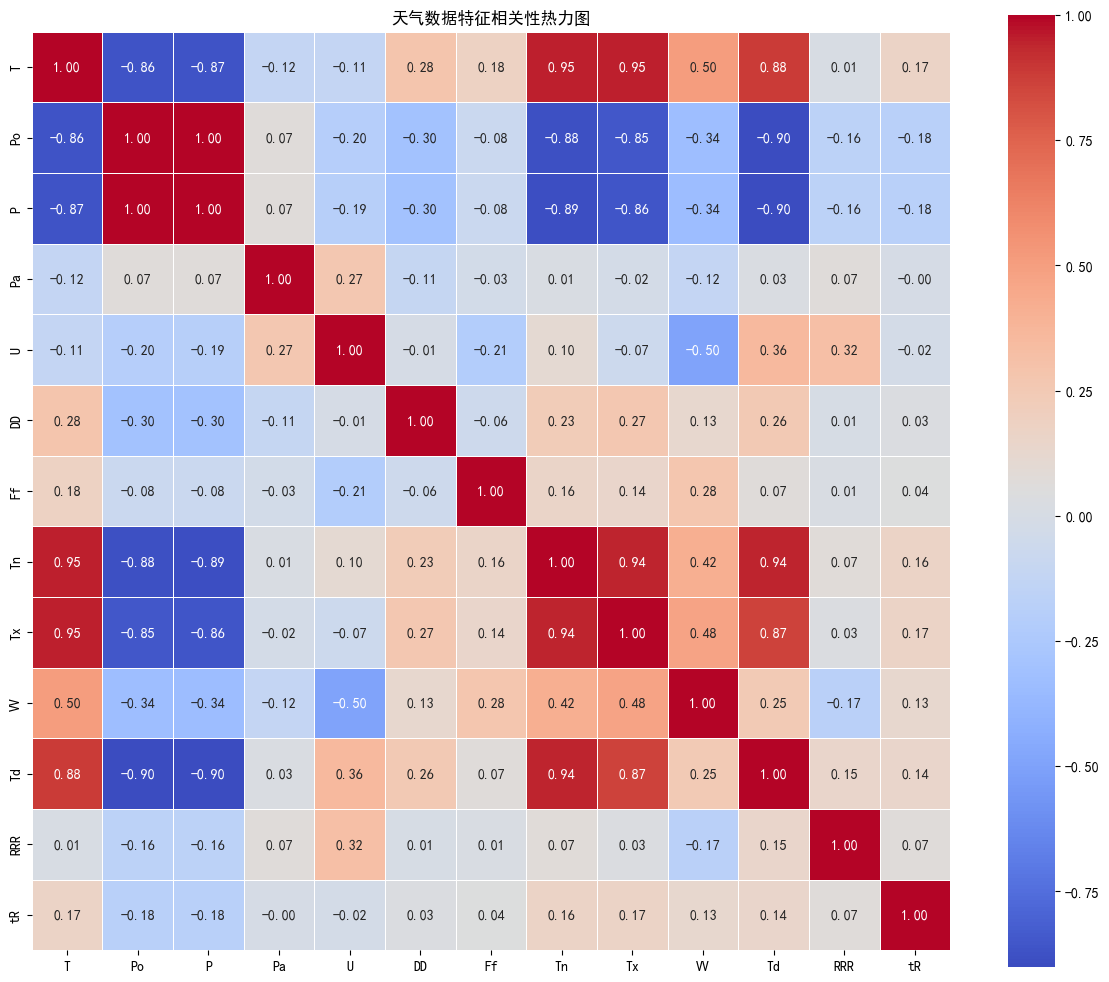

In [45]:
numeric_df = df.select_dtypes(include=[np.number])

# 检查缺失值情况
print(numeric_df.isnull().sum())

# 可以选择用均值填充缺失值，或直接丢弃含缺失值的行
numeric_df = numeric_df.fillna(numeric_df.mean())

# 计算相关系数矩阵
corr_matrix = numeric_df.corr()

# 显示部分相关系数矩阵
corr_matrix.head()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('天气数据特征相关性热力图')
plt.tight_layout()
plt.show()